# Basic demonstration 

This notebook it intended to demonstrate some of the basic concepts in the new version of of the rompy code

- Separation of 'runtime' from 'config' - more on this later
- Modular
    - There are a number of core objects 
- Pydantic throughout
    - Strong typing
    - Clearly defined APIs
    - Built in validators
- Declaritive
    - The entire configuration to run the model is passed at intantiation. 
    - The core wrapper is a pycallable, making it play nicely with downstream workflow packages (e.g. airflow)
    - Can still be run proceduraly. 
- Separation of intake components. 
    - Common filters now available as a separate import. 
    - Data is provdided to the wrapper as large lazy datasets, and data selection is done based on runtime period and grid spatial extents
    - Substantially reduced the fricton to hook up a different dataset
    - Filters are still available to use in intake drivers where appropriate (e.g. where constructing nowcasts from many forecasts becomes memory prohibitive to do lazily)

In [1]:
# Set up notebook
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Import some core objects
from rompy import ModelRun
from rompy.core import TimeRange, BaseConfig, BaseGrid, RegularGrid, DatasetXarray
from rompy.swan import SwanConfig, SwanDataGrid, SwanGrid
from rompy.swan.data import SwanDataGrid
import xarray as xr
import numpy as np
import tempfile
import os
import pandas as pd
from datetime import datetime
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


In [3]:
# The highest level object is the ModelRun which is a generic class to run any model type. 
# Lets start by looking at the ModelRun api

ModelRun?

Init signature:
ModelRun(
    *,
    run_id: str = 'run_id',
    period: rompy.core.time.TimeRange = TimeRange(start=datetime.datetime(2020, 2, 21, 4, 0), end=datetime.datetime(2020, 2, 24, 4, 0), duration=datetime.timedelta(days=3), interval=datetime.timedelta(seconds=900), include_end=True),
    output_dir: str = './simulations',
    config: rompy.core.config.BaseConfig | rompy.swan.config.SwanConfig = BaseConfig(model_type='base', template='/source/rompy/rompy/templates/base', checkout='main'),
) -> None
Docstring:      A base class for all models
Init docstring:
Create a new model by parsing and validating input data from keyword arguments.

Raises ValidationError if the input data cannot be parsed to form a valid model.
File:           /source/rompy/rompy/model.py
Type:           ModelMetaclass
Subclasses:     

In [4]:
# So we can see that the ModelRun takes an id, a time run period, an output directort and a model configuration. 
 # TimeRange is a simple class that calculates run dates based on combinations of start, end, and interval.

TimeRange?

Init signature:
TimeRange(
    *,
    start: Optional[datetime.datetime] = None,
    end: Optional[datetime.datetime] = None,
    duration: Union[str, datetime.timedelta, NoneType] = None,
    interval: Union[str, datetime.timedelta, NoneType] = '1h',
    include_end: bool = True,
) -> None
Docstring:     
A time range object

Examples
--------
>>> from rompy import TimeRange
>>> tr = TimeRange(start="2020-01-01", end="2020-01-02")
>>> tr
TimeRange(start=datetime.datetime(2020, 1, 1, 0, 0), end=datetime.datetime(2020, 1, 2, 0, 0), duration=None, interval=None, include_end=True)
>>> tr = TimeRange(start="2020-01-01", duration="1d")
>>> tr
TimeRange(start=datetime.datetime(2020, 1, 1, 0, 0), end=datetime.datetime(2020, 1, 2, 0, 0), duration=timedelta(days=1), interval=None, include_end=True)
>>> tr = TimeRange(start="2020-01-01", duration="1d", interval="1h")
>>> tr
TimeRange(start=datetime.datetime(2020, 1, 1, 0, 0), end=None, duration=timedelta(days=1), interval=timedelta(hours=1), inc

In [5]:
# The model configuration is a generic object that can be used to configure any model type.

# The simplest model configuration is the BaseConfig on which all model configurations are based.

BaseConfig??

Init signature:
BaseConfig(
    *,
    model_type: Literal['base'] = 'base',
    template: Optional[str] = '/source/rompy/rompy/templates/base',
    checkout: Optional[str] = 'main',
    **extra_data: Any,
) -> None
Source:        
class BaseConfig(RompyBaseModel):
    """A base class for all templates"""

    model_type: Literal["base"] = "base"
    template: Optional[str] = Field(
        description="The path to the model template",
        default=DEFAULT_TEMPLATE,
    )
    checkout: Optional[str] = Field(
        description="The git branch to use if the template is a git repo",
        default="main",
    )

    class Config:
        extra = "allow"
File:           /source/rompy/rompy/core/config.py
Type:           ModelMetaclass
Subclasses:     SwanConfig, SwanConfigComponents

In [6]:
# So a configuraton is just a dictionary of key value pairs coupled with a path to a template to used to render these arguments (more on this later). 
# If the path to the template is a local file, this is used directly, if it points to a remote repository, that will be cloned locally using the 
# cookiecutter mechanics and the path to the local copy will be used.

In [7]:
# Before we start to look at the derived swan classes, lets look at a couple of other important base classes. 
# First, a generic model grid
BaseGrid?

Init signature:
BaseGrid(
    *,
    x: Optional[pydantic_numpy.ndarray.PydanticNDArray] = None,
    y: Optional[pydantic_numpy.ndarray.PydanticNDArray] = None,
    grid_type: Literal['base'] = 'base',
) -> None
Docstring:     
An object which provides an abstract representation of a grid in some geographic space

This is the base class for all Grid objects. The minimum representation of a grid are two
NumPy array's representing the vertices or nodes of some structured or unstructured grid,
its bounding box and a boundary polygon. No knowledge of the grid connectivity is expected.
Init docstring:
Create a new model by parsing and validating input data from keyword arguments.

Raises ValidationError if the input data cannot be parsed to form a valid model.
File:           /source/rompy/rompy/core/grid.py
Type:           ModelMetaclass
Subclasses:     RegularGrid

In [8]:
# Regular grids inherit from this base grid class, but can be defined by some simple paramaters due to their regular nature.
RegularGrid?

Init signature:
RegularGrid(
    *,
    x: Optional[pydantic_numpy.ndarray.PydanticNDArray] = None,
    y: Optional[pydantic_numpy.ndarray.PydanticNDArray] = None,
    grid_type: Literal['regular'] = 'regular',
    x0: Optional[float] = None,
    y0: Optional[float] = None,
    rot: Optional[float] = 0.0,
    dx: Optional[float] = None,
    dy: Optional[float] = None,
    nx: Optional[int] = None,
    ny: Optional[int] = None,
) -> None
Docstring:     
An object which provides an abstract representation of a regular grid in
some geographic space
Init docstring:
Create a new model by parsing and validating input data from keyword arguments.

Raises ValidationError if the input data cannot be parsed to form a valid model.
File:           /source/rompy/rompy/core/grid.py
Type:           ModelMetaclass
Subclasses:     SwanGrid

In [9]:
# Now lets look at some on the the swan specific classes that inherit from these base classes
from rompy.swan import SwanDataGrid, SwanGrid, SwanConfig

In [10]:
# Swan grid inherits from regular grid (for now) and adds some swan specific parameters such as
# exc and implements swan grid inpgrid and cgrid methods
SwanGrid?


Init signature:
SwanGrid(
    *,
    x: Optional[pydantic_numpy.ndarray.PydanticNDArray] = None,
    y: Optional[pydantic_numpy.ndarray.PydanticNDArray] = None,
    grid_type: Literal['REG'] = 'REG',
    x0: Optional[float] = None,
    y0: Optional[float] = None,
    rot: Optional[float] = 0.0,
    dx: Optional[float] = None,
    dy: Optional[float] = None,
    nx: Optional[int] = None,
    ny: Optional[int] = None,
    exc: Optional[float] = None,
    gridfile: Optional[rompy.swan.grid.ConstrainedStrValue] = None,
) -> None
Docstring:     
An object which provides an abstract representation of a regular SWAN
grid in some geographic space
Init docstring:
Create a new model by parsing and validating input data from keyword arguments.

Raises ValidationError if the input data cannot be parsed to form a valid model.
File:           /source/rompy/rompy/swan/grid.py
Type:           ModelMetaclass
Subclasses:     

In [11]:
SwanConfig?

Init signature:
SwanConfig(
    *,
    model_type: Literal['swan'] = 'swan',
    template: str = '/source/rompy/rompy/templates/swan',
    checkout: Optional[str] = 'main',
    grid: rompy.swan.grid.SwanGrid,
    spectral_resolution: rompy.swan.config.SwanSpectrum = SwanSpectrum(fmin=0.0464, fmax=1.0, nfreqs=31, ndirs=36),
    forcing: rompy.swan.config.ForcingData = ForcingData(bottom=None, wind=None, current=None, boundary=None),
    physics: rompy.swan.config.SwanPhysics = SwanPhysics(friction='MAD', friction_coeff=0.1),
    outputs: rompy.swan.config.Outputs = Outputs(grid=GridOutput(period=None, variables=['DEPTH', 'UBOT', 'HSIGN', 'HSWELL', 'DIR', 'TPS', 'TM01', 'WIND']), spec=SpecOutput(period=None, locations=OutputLocs
)),
    spectra_file: str = 'boundary.spec',
    **extra_data: Any,
) -> None
Docstring:      SWAN configuration
Init docstring:
Create a new model by parsing and validating input data from keyword arguments.

Raises ValidationError if the input data cannot be pa

In [12]:
# So we can see that the SwanConfig is a BaseConfig with some additional arguments.
# These arguments are broken up into several compoents, lets examine these individually.
from rompy.swan.config import SwanSpectrum, ForcingData, SwanPhysics, Outputs, SwanDataGrid

In [13]:
SwanSpectrum?

Init signature:
SwanSpectrum(
    *,
    fmin: float = 0.0464,
    fmax: float = 1.0,
    nfreqs: int = 31,
    ndirs: int = 36,
) -> None
Docstring:      SWAN Spectrum
Init docstring:
Create a new model by parsing and validating input data from keyword arguments.

Raises ValidationError if the input data cannot be parsed to form a valid model.
File:           /source/rompy/rompy/swan/config.py
Type:           ModelMetaclass
Subclasses:     

In [14]:
SwanDataGrid?

Init signature:
SwanDataGrid(
    *,
    id: str,
    dataset: rompy.core.data.DatasetXarray | rompy.core.data.DatasetIntake,
    filter: Optional[rompy.core.filters.Filter] = Filter(sort={}, subset={}, crop={}, timenorm={}, rename={}, derived={}),
    variables: Optional[list[str]] = [],
    latname: Optional[str] = 'latitude',
    lonname: Optional[str] = 'longitude',
    timename: Optional[str] = 'time',
    z1: str = None,
    z2: str = None,
    var: str = 'WIND',
) -> None
Docstring:      This class is used to write SWAN data from a dataset.
Init docstring:
Create a new model by parsing and validating input data from keyword arguments.

Raises ValidationError if the input data cannot be parsed to form a valid model.
File:           /source/rompy/rompy/swan/data.py
Type:           ModelMetaclass
Subclasses:     

In [15]:
SwanPhysics?

Init signature: SwanPhysics(*, friction: str = 'MAD', friction_coeff: float = 0.1) -> None
Docstring:      Container class represting configuraable SWAN physics options
Init docstring:
Create a new model by parsing and validating input data from keyword arguments.

Raises ValidationError if the input data cannot be parsed to form a valid model.
File:           /source/rompy/rompy/swan/config.py
Type:           ModelMetaclass
Subclasses:     

In [16]:
ForcingData?

Init signature:
ForcingData(
    *,
    bottom: rompy.swan.data.SwanDataGrid | None = None,
    wind: rompy.swan.data.SwanDataGrid | None = None,
    current: rompy.swan.data.SwanDataGrid | None = None,
    boundary: rompy.swan.boundary.DataBoundary | None = None,
) -> None
Init docstring:
Create a new model by parsing and validating input data from keyword arguments.

Raises ValidationError if the input data cannot be parsed to form a valid model.
File:           /source/rompy/rompy/swan/config.py
Type:           ModelMetaclass
Subclasses:     

In [17]:
SwanGrid?

Init signature:
SwanGrid(
    *,
    x: Optional[pydantic_numpy.ndarray.PydanticNDArray] = None,
    y: Optional[pydantic_numpy.ndarray.PydanticNDArray] = None,
    grid_type: Literal['REG'] = 'REG',
    x0: Optional[float] = None,
    y0: Optional[float] = None,
    rot: Optional[float] = 0.0,
    dx: Optional[float] = None,
    dy: Optional[float] = None,
    nx: Optional[int] = None,
    ny: Optional[int] = None,
    exc: Optional[float] = None,
    gridfile: Optional[rompy.swan.grid.ConstrainedStrValue] = None,
) -> None
Docstring:     
An object which provides an abstract representation of a regular SWAN
grid in some geographic space
Init docstring:
Create a new model by parsing and validating input data from keyword arguments.

Raises ValidationError if the input data cannot be parsed to form a valid model.
File:           /source/rompy/rompy/swan/grid.py
Type:           ModelMetaclass
Subclasses:     

(<Figure size 1000x706.373 with 1 Axes>, <GeoAxes: >)

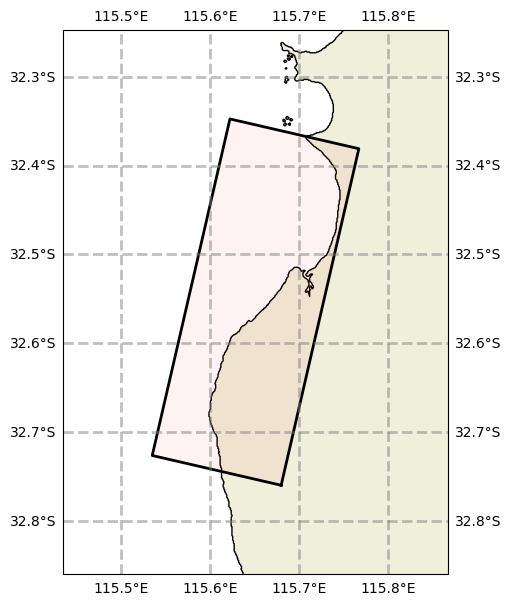

In [18]:
# Lets start by intantiaing a Swan grid

grid = SwanGrid(x0=115.68, y0=-32.76, dx=0.001, dy=0.001, nx=390, ny=150, rot=77)
grid.plot()

In [19]:
# Now lets look at how we might use that grid to define some data inputs
SwanDataGrid?

Init signature:
SwanDataGrid(
    *,
    id: str,
    dataset: rompy.core.data.DatasetXarray | rompy.core.data.DatasetIntake,
    filter: Optional[rompy.core.filters.Filter] = Filter(sort={}, subset={}, crop={}, timenorm={}, rename={}, derived={}),
    variables: Optional[list[str]] = [],
    latname: Optional[str] = 'latitude',
    lonname: Optional[str] = 'longitude',
    timename: Optional[str] = 'time',
    z1: str = None,
    z2: str = None,
    var: str = 'WIND',
) -> None
Docstring:      This class is used to write SWAN data from a dataset.
Init docstring:
Create a new model by parsing and validating input data from keyword arguments.

Raises ValidationError if the input data cannot be parsed to form a valid model.
File:           /source/rompy/rompy/swan/data.py
Type:           ModelMetaclass
Subclasses:     

In [20]:
# Here we are creating some dummy data here to use as a bathymetry input
from rompy.swan import SwanDataGrid
os.makedirs("simulations/test_swantemplate/datasets", exist_ok=True)
datagrid = SwanGrid(x0=115.68, y0=-32.76, rot=77, nx=391, ny=151, dx=0.01, dy=0.01, exc=-99.0)

def nc_bathy(bottom=datagrid):
    # touch temp netcdf file
    tmp_path = tempfile.mkdtemp()
    source = os.path.join("simulations", "test_swantemplate", "datasets", "bathy.nc")
    bbox = bottom.bbox(buffer=1)
    lat = np.arange(bbox[1], bbox[3], bottom.dy)
    lon = np.arange(bbox[0], bbox[2], bottom.dx)
    ds = xr.Dataset(
        {
            "depth": xr.DataArray(
                np.random.rand(lat.size, lon.size),
                dims=["lat", "lon"],
                coords={"lat": lat, "lon": lon},
            ),
        }
    )
    ds.to_netcdf(source, mode="w")
    return source

# and same again for wind
def nc_data_source(wind_grid=datagrid):
    tmp_path = tempfile.mkdtemp()
    source = os.path.join("simulations", "test_swantemplate", "datasets", "wind_inputs.nc")

    bbox = wind_grid.bbox(buffer=1)
    lat = np.arange(bbox[1], bbox[3], wind_grid.dy)
    lon = np.arange(bbox[0], bbox[2], wind_grid.dx)
    time = pd.date_range("2023-01-01", periods=10)

    ds = xr.Dataset(
        {
            "u": xr.DataArray(
                np.random.rand(10, lat.size, lon.size),
                dims=["time", "lat", "lon"],
                coords={
                    "time": time,
                    "lat": lat,
                    "lon": lon,
                },
            ),
            "v": xr.DataArray(
                np.random.rand(10, lat.size, lon.size),
                dims=["time", "lat", "lon"],
                coords={
                    "time": time,
                    "lat": lat,
                    "lon": lon,
                },
            ),
        }
    )
    ds.to_netcdf(source, mode="w")
    return source

(<Figure size 800x1132.56 with 2 Axes>, <GeoAxes: xlabel='lon', ylabel='lat'>)

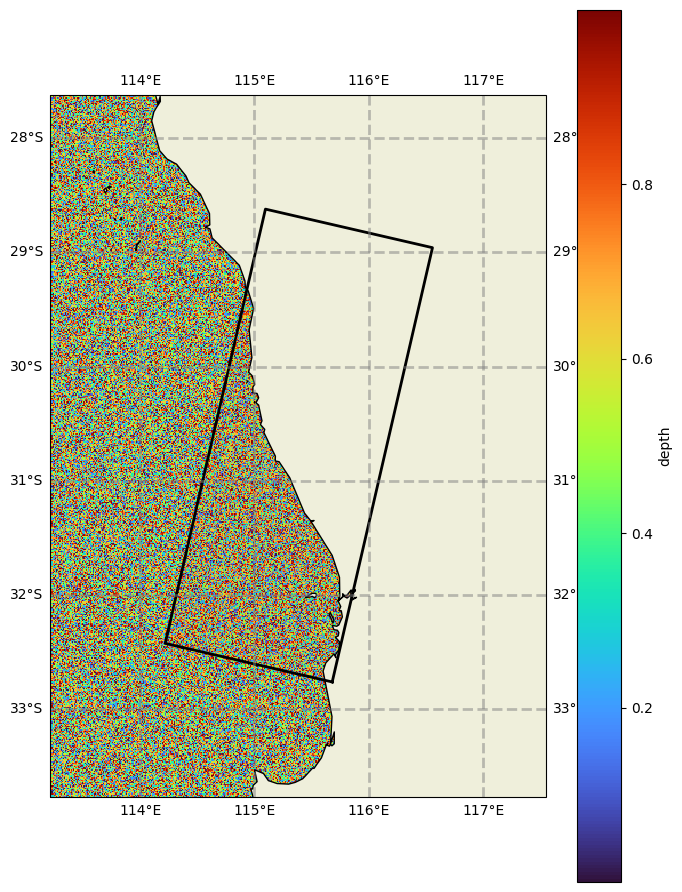

In [21]:
# Create dummy data
bathy_source = nc_bathy()

# Intantiate a swan data object using this dummy data as input
bathy = SwanDataGrid(
        id="bottom", dataset=DatasetXarray(uri=bathy_source), z1="depth", var="BOTTOM", latname="lat", lonname="lon"
    )

# Plot the full dataset
bathy.plot(param='depth', fscale=8, model_grid=datagrid)


In [22]:
# If we run the bathy get method, this will write the data in swan format to the stage directory ready for ingestion into the model. 
# At the moment, this is the full dataset, but we will look at subsetting options later
# Note that running this method retuns the required control file commands to read the data
# from the control file

bathy.get('./')

INFO:rompy.swan.data:	Writing bottom to ./bottom.grd


"INPGRID BOTTOM REG 113.21844490282216 -33.76 0.0 433 613 0.010000000000005116 0.00999999999999801 EXC -99.0\nREADINP BOTTOM 1.0 'bottom.grd' 3 FREE\n"

INFO:rompy.swan.data:	Writing bottom to ./bottom.grd


(<Figure size 700x1195.26 with 2 Axes>, <GeoAxes: xlabel='lon', ylabel='lat'>)

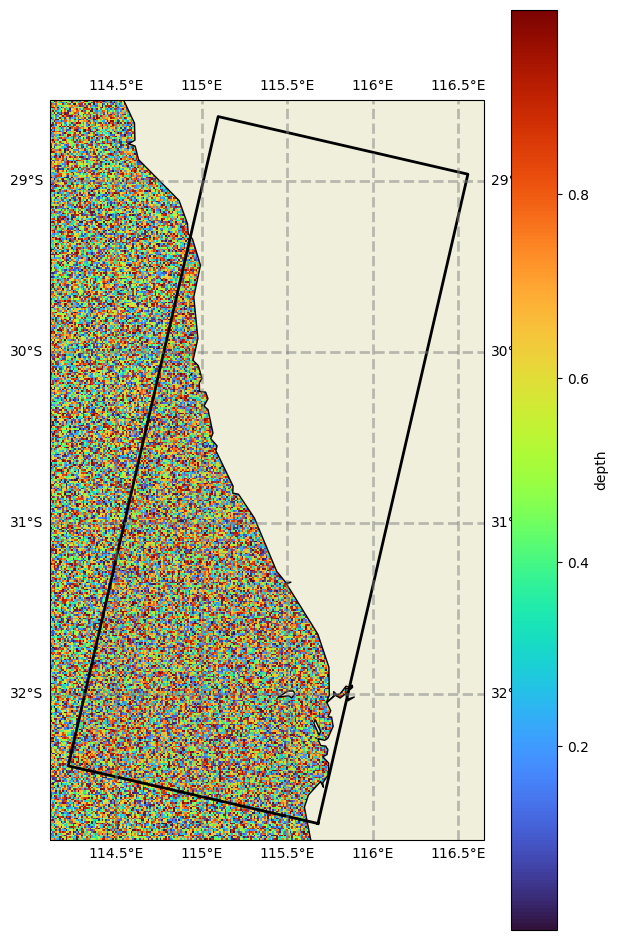

In [23]:
# But instead of just using the data as is, we can use filters to subset it. There are a number of filters available. 
# Here we just demonstrate some hidden convenience functions which use a model grid to subset space. 

bathy._filter_grid(datagrid)
bathy.get('./')
bathy.plot(param='depth', fscale=7, model_grid=datagrid)

In [24]:

# This has now extracted only what it needs based on the grid extents. 
# This is what is done internally in the wrapper (in addition to a analogous time filtering function) allowing us to use lazy grids without doing any pre-filtering, 
# and have the wrapper use only what it needs

In [25]:
# Wind data works the same way. Note the control file input commands are different as it now applied to wind data
wind_source = nc_data_source()
wind = SwanDataGrid(id="wind", var="WIND", dataset=DatasetXarray(uri=wind_source), z1="u", z2="v")
wind.get('./')

INFO:rompy.swan.data:	Writing wind to ./wind.grd


"INPGRID WIND REG 113.21844490282216 -33.76 0.0 433 613 0.010000000000005116 0.00999999999999801 NONSTATION 20230101.000000 24.0 HR\nREADINP WIND 1 'wind.grd' 3 0 1 0 FREE\n"

In [26]:
# The boundary object work in a similar way but is a little more complex as it must determine points around the boundary of the model domain.
# First lets have a look at the boundary object
from rompy.swan import DataBoundary
DataBoundary?

Init signature:
DataBoundary(
    *,
    id: str,
    dataset: rompy.core.data.DatasetXarray | rompy.core.data.DatasetIntake | rompy.swan.boundary.DatasetWavespectra,
    filter: Optional[rompy.core.filters.Filter] = Filter(sort={}, subset={}, crop={}, timenorm={}, rename={}, derived={}),
    variables: Optional[list[str]] = [],
    latname: Optional[str] = 'latitude',
    lonname: Optional[str] = 'longitude',
    timename: Optional[str] = 'time',
    spacing: Optional[float] = None,
    sel_method: Literal['idw', 'nearest'] = 'idw',
    tolerance: rompy.swan.boundary.ConstrainedFloatValue = 1.0,
    rectangle: Literal['closed', 'open'] = 'closed',
) -> None
Docstring:     
SWAN BOUNDNEST1 NEST data class.

Notes
-----
The `tolerance` behaves differently with sel_methods `idw` and `nearest`; in `idw`
sites with no enough neighbours within `tolerance` are masked whereas in `nearest`
an exception is raised (see wavespectra documentation for more details).

Be aware that when using `idw` 

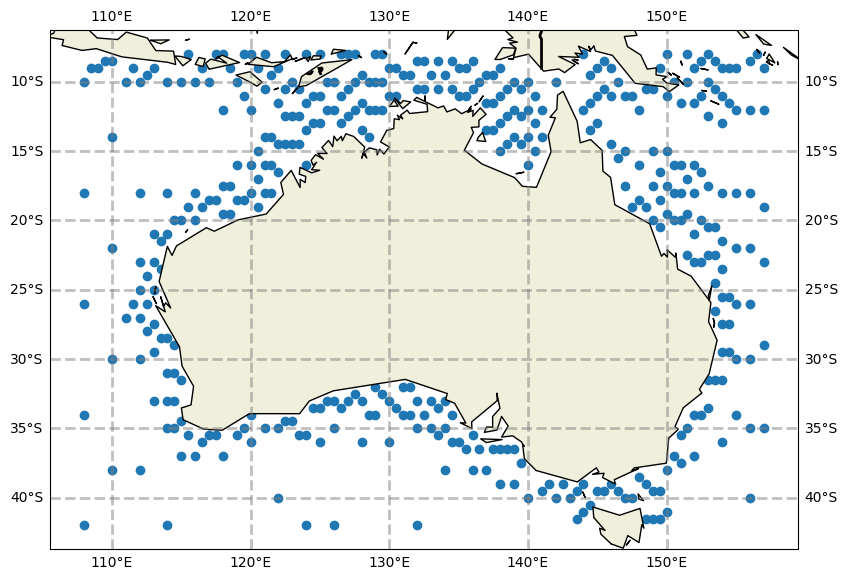

In [27]:
# Here we use a test boundary dataset

# Instantiate the boundary object
bnd = DataBoundary(id='bnd', dataset=DatasetXarray(uri="../tests/data/aus-20230101.nc"), latname='lat', lonname='lon', time='time', tolerance=0.1, sel_method='idw')

# plot the unfiltered data locations
bnd.plot(model_grid=grid)
#bnd.ds

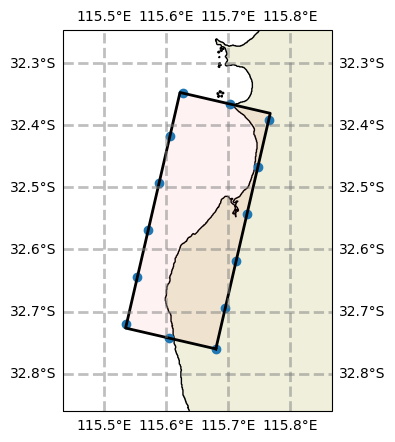

In [28]:
# Now we can filter the boundary data to the model grid. Here we just use a convenience function to plot the results of this effort 
# TODO - a bit more exlanation needed here

bnd.plot_boundary(grid, fscale=7)

In [29]:
# Putting these together we can create a swan forcing object When used in a model run, this object will loop over all the data source, filter in time and space to match the model run, 
# write the data to the scratch space, and produce the required control file inputs for swan
forcing = ForcingData(wind=wind, bottom=bathy, boundary=bnd)
forcing.get?

Signature:
forcing.get(
    grid: rompy.swan.grid.SwanGrid,
    period: rompy.core.time.TimeRange,
    staging_dir: pathlib.Path,
)
Docstring: <no docstring>
File:      /source/rompy/rompy/swan/config.py
Type:      method

In [30]:
# Next, lets look at the physics object. At the moment, this is very simple and only 
# templates friction in line with the old rompy, but this is now very easy to 
# extend to other physics options
SwanPhysics?

Init signature: SwanPhysics(*, friction: str = 'MAD', friction_coeff: float = 0.1) -> None
Docstring:      Container class represting configuraable SWAN physics options
Init docstring:
Create a new model by parsing and validating input data from keyword arguments.

Raises ValidationError if the input data cannot be parsed to form a valid model.
File:           /source/rompy/rompy/swan/config.py
Type:           ModelMetaclass
Subclasses:     

In [31]:
# Just as a demonstration of a custom validation error, lets try to instantiate a physics object with an invalid friction option
try:
    physics = SwanPhysics(friction='INVALID')
except ValueError as e:
    logger.warning(e)

friction
  friction must be one of JON, COLL, MAD or RIP (type=value_error)


In [32]:
# Now lets instantiate a valid physics object
physics = SwanPhysics()

# And render its cmd file method
print(physics.cmd)

GEN3 WESTH 0.000075 0.00175
BREAKING
FRICTION MAD 0.1

TRIADS

PROP BSBT
NUM ACCUR 0.02 0.02 0.02 95 NONSTAT 20



In [33]:
# Finally, the outputs object is used to define the outputs of the model run.
# These specify grid variables and spectral locations to be outputted. 
# They also define a period for output, which defaults to the full model run
Outputs?

Init signature:
Outputs(
    *,
    grid: rompy.swan.config.GridOutput = GridOutput(period=None, variables=['DEPTH', 'UBOT', 'HSIGN', 'HSWELL', 'DIR', 'TPS', 'TM01', 'WIND']),
    spec: rompy.swan.config.SpecOutput = SpecOutput(period=None, locations=OutputLocs
),
) -> None
Docstring:      Outputs for SWAN
Init docstring:
Create a new model by parsing and validating input data from keyword arguments.

Raises ValidationError if the input data cannot be parsed to form a valid model.
File:           /source/rompy/rompy/swan/config.py
Type:           ModelMetaclass
Subclasses:     

In [34]:
# TODO fix below
#outputs = Outputs(spec=SpecOutput(locations=[[115.68, -32.76]]), period=TimeRange(start=datetime(2020, 2, 21), end=datetime(2020, 2, 22)))

# Instantiate default model output
outputs = Outputs()
outputs

Outputs(grid=GridOutput(period=None, variables=['DEPTH', 'UBOT', 'HSIGN', 'HSWELL', 'DIR', 'TPS', 'TM01', 'WIND']), spec=SpecOutput(period=None, locations=OutputLocs
))

In [35]:
# Lets now put those components into a swan config object and instantiate a model run

run = ModelRun(
        run_id="test_swantemplate",
        period=TimeRange(start=datetime(2023, 1, 1, 0), end=datetime(2023, 1, 4, 4)),
        output_dir="simulations",
        config=SwanConfig(
            grid=grid,
            physics=physics,
            forcing=forcing,
            outputs=outputs,
        )
    )

(<Figure size 1000x706.373 with 1 Axes>, <GeoAxes: >)

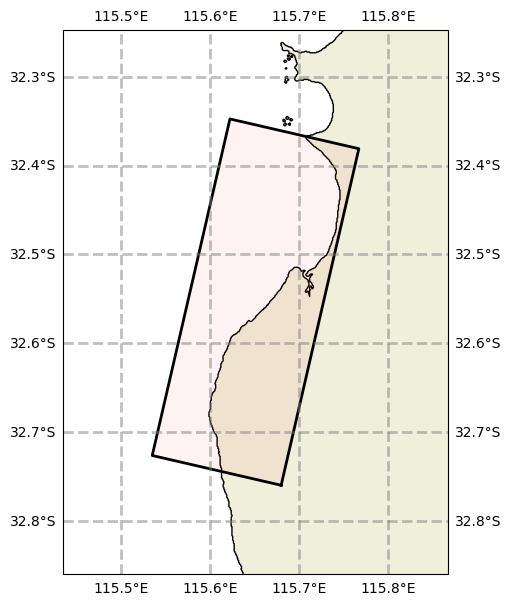

In [36]:
# This grid object is still accessible as before, but the path has changed slightly
run.config.grid.plot()

In [37]:
# And we can also run individual components and look at the control file inputs
cmd = run.config.forcing.get(grid=run.config.grid, runtime=run)
print(cmd['forcing'])
print(cmd['boundary'])

TypeError: ForcingData.get() got an unexpected keyword argument 'runtime'

In [ ]:
run.config.outputs.spec.locations

OutputLocs

In [ ]:
run()

INFO:rompy.model:
INFO:rompy.model:-----------------------------------------------------
INFO:rompy.model:Model settings:
INFO:rompy.model:
period: 

	Start: 2023-01-01 00:00:00
	End: 2023-01-04 04:00:00
	Duration: 3 days, 4:00:00
	Interval: 1:00:00
	Include End: True


output_dir: 
simulations

config: 
grid: 
	SwanGrid: REG, 390x150
spectral_resolution: 
	fmin=0.0464 fmax=1.0 nfreqs=31 ndirs=36
forcing: 
	bottom: DatasetXarray(uri=simulations/test_swantemplate/datasets/bathy.nc
	wind: DatasetXarray(uri=simulations/test_swantemplate/datasets/wind_inputs.nc
	boundary: DatasetXarray(uri=../tests/data/aus-20230101.nc

physics: 
	friction='MAD' friction_coeff=0.1
outputs: 
	Grid:
	variables: DEPTH UBOT HSIGN HSWELL DIR TPS TM01 WIND
	Spec
		locations: 

template: 
	/source/rompy/rompy/templates/swan

INFO:rompy.model:-----------------------------------------------------
INFO:rompy.model:Generating model input files in simulations
INFO:rompy.swan.config:	 Processing bottom forcing
INFO:rom

'/source/rompy/notebooks/simulations/test_swantemplate'

# Command line interface


In [ ]:
# Another advantage of using a declaritive model is that configuration becomes much easier to manage. 
# We have steped through each object separately, but the whole model run can be described with simple 
# arguments. To illustrate this, lets load a simple configuration file to describes the full model run above. 

!cat demo.yml

# Note that this is config fully replicates the config deomonstrated in the demo notebook,
# however it requireds the datasets created in that notebook to work. 

run_id: test_swantemplate 
period:
  start: 20230101T00
  # end: 20200224T04
  duration: 3d
  interval: 1h
output_dir: simulations
config:
  model_type: swan
  grid:
    x0: 115.68
    y0: -32.76
    rot: 77.0
    dx: 0.001
    dy: 0.001
    nx: 390
    ny: 150
    gridtype: REG
  spectral_resolution:
    fmin: 0.0464
    fmax: 1.0
    nfreqs: 31
    ndirs: 36
  forcing:
    wind:
      model_type: swan
      id: wind 
      var: WIND 
      dataset: 
        uri: simulations/test_swantemplate/datasets/wind_inputs.nc
        model_type: xarray
      z1: u
      z2: v
      latname: lat
      lonname: lon
    bottom: 
      id: bottom
      var: BOTTOM
      dataset: 
        uri: simulations/test_swantemplate/datasets/bathy.nc
        model_type: xarray
      z1: depth
      latname: lat
      lonname: lon
    boundary:
     

In [ ]:
# initantiating a model run using this config
import yaml
args = yaml.load(open('demo.yml', 'r'), Loader=yaml.FullLoader)

run = ModelRun(**args)

# and then calling as before
run()

INFO:rompy.model:
INFO:rompy.model:-----------------------------------------------------
INFO:rompy.model:Model settings:
INFO:rompy.model:
period: 

	Start: 2023-01-01 00:00:00
	End: 2023-01-04 00:00:00
	Duration: 3 days, 0:00:00
	Interval: 1:00:00
	Include End: True


output_dir: 
simulations

config: 
grid: 
	SwanGrid: REG, 390x150
spectral_resolution: 
	fmin=0.0464 fmax=1.0 nfreqs=31 ndirs=36
forcing: 
	bottom: DatasetXarray(uri=simulations/test_swantemplate/datasets/bathy.nc
	wind: DatasetXarray(uri=simulations/test_swantemplate/datasets/wind_inputs.nc
	boundary: DatasetXarray(uri=../tests/data/aus-20230101.nc

physics: 
	friction='MAD' friction_coeff=0.1
outputs: 
	Grid:
	variables: DEPTH UBOT HSIGN HSWELL DIR TPS TM01 WIND
	Spec
		locations: 

template: 
	/source/rompy/rompy/templates/swan

INFO:rompy.model:-----------------------------------------------------
INFO:rompy.model:Generating model input files in simulations
INFO:rompy.swan.config:	 Processing bottom forcing
INFO:rom

'/source/rompy/notebooks/simulations/test_swantemplate'

In [ ]:
# There is also a command line interface to run defined model configuration

!rompy --help

Usage: rompy [OPTIONS] {base|swan} CONFIG

  Run model Usage: rompy <model> config.yml Args:     model(str): model type
  config(str): yaml config file

Options:
  -k, --kwargs TEXT  additional key value pairs in the format key:value
  --help             Show this message and exit.


In [ ]:
!rompy swan demo.yml

INFO:rompy.model:
INFO:rompy.model:-----------------------------------------------------
INFO:rompy.model:Model settings:
INFO:rompy.model:
period: 

	Start: 2023-01-01 00:00:00
	End: 2023-01-04 00:00:00
	Duration: 3 days, 0:00:00
	Interval: 1:00:00
	Include End: True


output_dir: 
simulations

config: 
grid: 
	SwanGrid: REG, 390x150
spectral_resolution: 
	fmin=0.0464 fmax=1.0 nfreqs=31 ndirs=36
forcing: 
	bottom: DatasetXarray(uri=simulations/test_swantemplate/datasets/bathy.nc
	wind: DatasetXarray(uri=simulations/test_swantemplate/datasets/wind_inputs.nc
	boundary: DatasetXarray(uri=../tests/data/aus-20230101.nc

physics: 
	friction='MAD' friction_coeff=0.1
outputs: 
	Grid:
	variables: DEPTH UBOT HSIGN HSWELL DIR TPS TM01 WIND
	Spec
		locations: 

template: 
	/source/rompy/rompy/templates/swan

INFO:rompy.model:-----------------------------------------------------
INFO:rompy.model:Generating model input files in simulations
INFO:rompy.swan.config:	 Processing bottom forcing
INFO:rom

In [ ]:
# So hopefully that gives a the basic functionality. A bit more detail on templates is given in template_demo.ipynb